In [1]:
import scanpy as sc

import gc

In [2]:
import pandas as pd
import csv
import networkx as nx

In [45]:
import torch.nn as nn
import torch 
import torch.nn.functional as F

# Model Definition for scEGA


My column vector is my vector of cell features, each column would contain the features of the cell matrix.

In [50]:
class graphattention_layer(nn.Module):
    def __init__(self,input_size,output_size,adjM):
        #WkH_{i-1} is of dimension : CurrentNodeShape x N  
        self.inpshape = input_size
        self.opshape = output_size
        self.A = adjM
        super(graphattention_layer,self).__init__()
        self.vkt = nn.Linear(in_features=output_size,out_features=  1)
        self.vkr = nn.Linear(in_features=output_size,out_features= 1)
        self.W =  nn.Linear(in_features=input_size,out_features=output_size) 
    def forward(self, H_k):
        #H_k represents the previous layer's graph representation
        M_s = self.A * self.vkt(F.relu(self.W(H_k))).T
        M_r = (self.A * self.vkr(F.relu(self.W(H_k))).T).T
        Attention = F.softmax(F.sigmoid(M_s+M_r))
        H_new = Attention@F.relu(self.W(H_k))
        return H_new

In [41]:
class encoder(nn.Module):
    def __init__(self,adjM):
        super(encoder,self).__init__( )
        #remember that in pytorch, your input_size is the last dimension of your input
        # So when my input is F*N, input_size = F
        # also a row in my matrix corresponds to a cell's representation
        self.layer1 = graphattention_layer(input_size=adjM.shape[0]
                                           ,output_size=512
                                           ,adjM=adjM)
        self.layer1 = graphattention_layer(input_size=512
                                           ,output_size=256
                                           ,adjM=adjM)
        self.layer1 = graphattention_layer(input_size=256
                                           ,output_size=64
                                           ,adjM=adjM)
    def forward(self, X):
        # X here is the adjacency matrix representing the cell graph
        # I'm gonna tranpose it once in the start, and then at the end.
        H1 = self.layer1(X.T)
        H2 = self.layer2(H1)
        H3 = self.layer3(H2)
        # H3 is of size N*64
        # I'm gonna transpose it back to 64*N
        return H3.T  

In [42]:
class decoder(nn.Module):
    def __init__(self,adjM,GeneGraph):
        super(encoder,self).__init__()
        self.gGraph = GeneGraph
        self.layer1 = graphattention_layer(input_size=64,
                                           output_size=256,adjM=adjM)
        self.layer1 = graphattention_layer(input_size=256,
                                           output_size=512,adjM=adjM)
        self.layer1 = graphattention_layer(input_size=512,
                                           output_size=adjM.shape[0],adjM=adjM)
    def forward(self, H):
        decoderPass = torch.stack(self.gGraph,H)
        H1 = self.layer1(decoderPass)
        H2 = self.layer2(H1)
        H3 = self.layer3(H2)
        return H3

In [43]:
class scdEGA(nn.Module):
    def __init__(self,hidden_size,adjM,GeneGraph):
        super.__init__(scdEGA)
        self.encoder = encoder(hidden_size,adjM)
        self.decoder = decoder(hidden_size,adjM,GeneGraph)
    def forward(self, H):
        H1 = self.encoder(H)
        H2 = self.decoder(H1)
        return H2

In [54]:
check = graphattention_layer(input_size=50,output_size=500,adjM=torch.rand(size=(50,50)))
import torch.nn.functional as F
mat = torch.rand(size=(50,50)) # 50 nodes , each of a feature size of 100
print(check(mat).shape)
check2 = graphattention_layer(input_size=500,output_size=256,adjM=torch.rand(size=(50,50)))
print(check2(check(mat)).shape)

torch.Size([50, 500])
torch.Size([50, 256])


C:\Users\saira\AppData\Local\Temp\ipykernel_19660\2287190896.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Attention = F.softmax(F.sigmoid(M_s+M_r))


In [39]:
import torch.nn.functional as F
a =torch.rand(size=(100,50))
print(F.relu(a))

tensor([[0.0178, 0.1044, 0.8450,  ..., 0.5303, 0.2048, 0.2422],
        [0.2655, 0.8623, 0.7302,  ..., 0.1370, 0.3929, 0.0760],
        [0.8447, 0.1127, 0.7694,  ..., 0.5359, 0.2548, 0.8397],
        ...,
        [0.5102, 0.9160, 0.2648,  ..., 0.3546, 0.8434, 0.4361],
        [0.8331, 0.6812, 0.5722,  ..., 0.3386, 0.1676, 0.7907],
        [0.1214, 0.4608, 0.1921,  ..., 0.2122, 0.6379, 0.6809]])


## Part 1:Data preprocessing

This will involve the following steps:
1. Obtaining a knn cell-cell graph
2. Obtaining a gene-gene graph based on protein-protein interactomes from https://string-db.org/cgi/network?taskId=bSmGYnEnGRS8&sessionId=bG2dm5uLdSGY

### Step 1 : Obtaining Cell matrix

In [55]:
adata = sc.read_text("./GSE57249_fpkm.txt")
adata = adata.T
sc.pp.pca(adata)

In [56]:
adata

AnnData object with n_obs × n_vars = 56 × 25737
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [57]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 56 × 25737
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

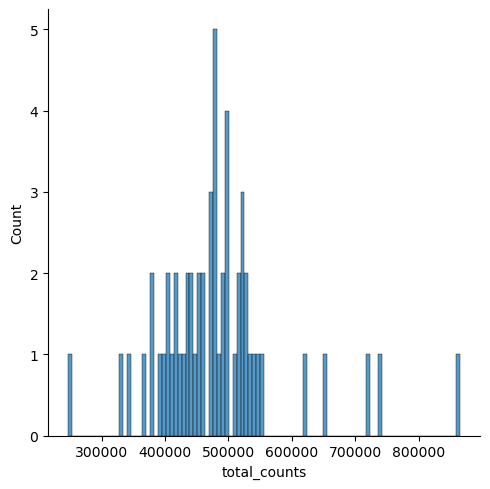

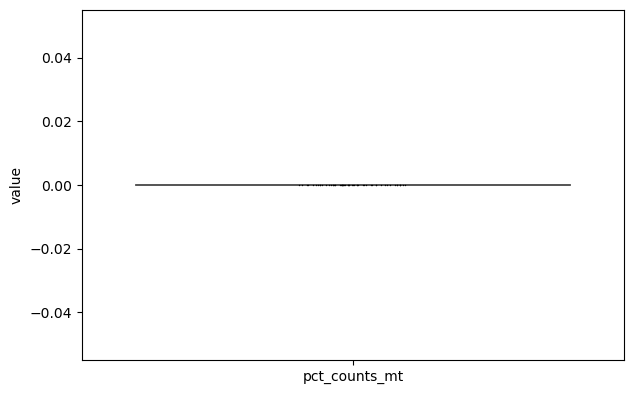

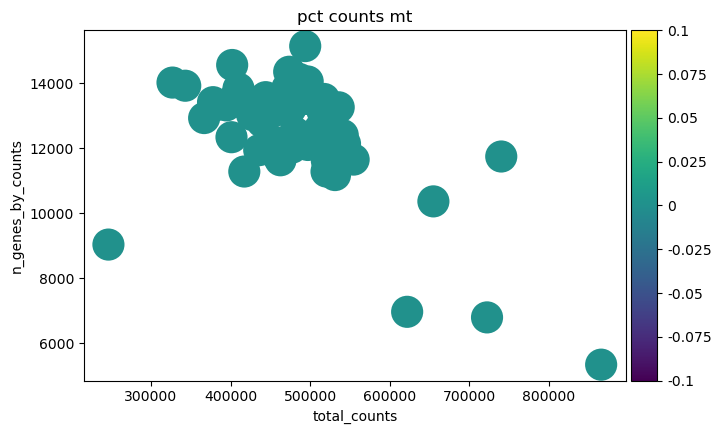

In [58]:
import seaborn as sns
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Theres like no mtrna lol.

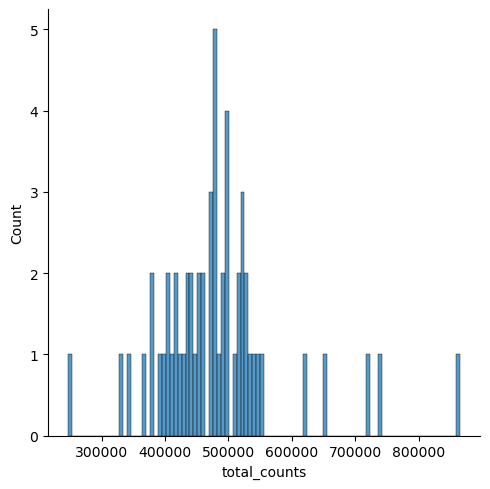

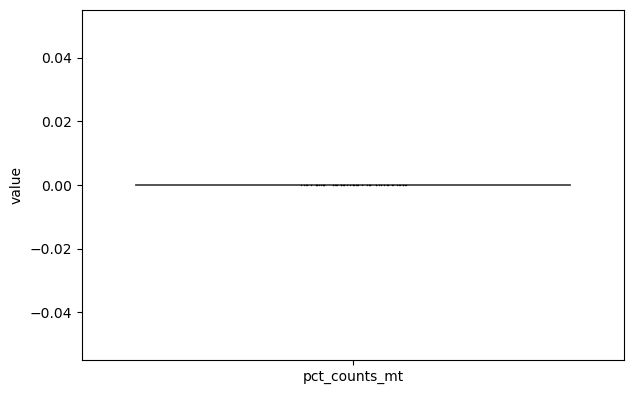

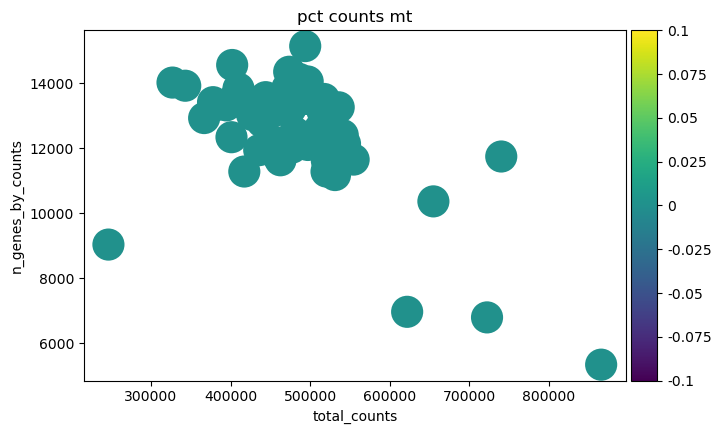

In [59]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [60]:

# Remove cells with a minimum number of expressed genes
sc.pp.filter_cells(adata, min_genes=3)

# Print the updated shape of the AnnData object
print("Updated shape:", adata.shape)

Updated shape: (56, 25737)


In [61]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
adj_list = adata.obsp["distances"].indices.reshape(adata.shape[0],-1)

c:\Users\saira\anaconda3\envs\Pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [62]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)


c:\Users\saira\anaconda3\envs\Pytorch\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [63]:
sc.neighbors.neighbors(adata.T,5)

c:\Users\saira\anaconda3\envs\Pytorch\Lib\site-packages\scanpy\tools\_utils.py:41: UserWarning: You’re trying to run this on 56 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


Our adjacency matrix in this case is simply our knn matrix, where we store the indices("is:cells"), whose expressions are closest to the cell of that row.

In [64]:
A = torch.zeros(size=(adata.T.shape[1],adata.T.shape[1]))
for i in range(adj_list.shape[0]):
    for j in range(5):
        A[i][adj_list[i][j]] = 1

Now to obtain the gene-gene graph



In [19]:
with open("highly_variable_genes.txt", "w") as f:    
     f.write(','.join(adata.var_names[adata.var["highly_variable"]]))

In [65]:
edge_list = pd.DataFrame(csv.reader(open("string_interactions.tsv"),delimiter="\t"))
edge_list.columns = edge_list.iloc[0]
edge_list = edge_list.drop(0)

In [66]:
gene_graph = nx.Graph()
gene_graph.add_edges_from(edge_list[["node1_string_id","node2_string_id"]].values)

In [35]:
import node2vec

In [ ]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(gene_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Learn embeddings
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get embeddings for each node
node_embeddings = model.wv.vectors

In [23]:

# for i in range(edge_list.shape[0]):
#     gene_graph.add_edge(edge_list., edge_list.iloc[i,1])